# Adaptive PDE discretizations on cartesian grids 
## Volume : GPU accelerated methods
## Part : Eikonal equations, acceleration and reproducibility
## Chapter : Walls and obstacles

We compute minimal paths in domains featuring obstacles, and check that the CPU and GPU codes provide consistent results.

In [123]:
large_instances=True

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"../..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Flow_Repro','GPU'))

In [2]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [3]:
from agd import HFMUtils
from agd import AutomaticDifferentiation as ad
from agd import Metrics
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
import agd.AutomaticDifferentiation.cupy_generic as cugen
norm_infinity = ad.Optimization.norm_infinity

from Notebooks_GPU.ExportedCode.Isotropic_Repro import RunCompare
from Notebooks_NonDiv.ExportedCode.LinearMonotoneSchemes2D import streamplot_ij

In [4]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,ad,cugen,RunGPU
    HFMUtils,ad,cugen = rreload([HFMUtils,ad,cugen],"../..")
    HFMUtils.dictIn.RunSmart = cugen.cupy_get_args(HFMUtils.RunSmart,dtype64=True,iterables=(dict,Metrics.Base))

In [5]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
HFMUtils.dictIn.RunSmart = cugen.cupy_get_args(HFMUtils.RunSmart,dtype64=True,iterables=(dict,Metrics.Base))

## 1. Isotropic metrics

In [115]:
ReloadPackages()

In [116]:
n=201
hfmIn = HFMUtils.dictIn({
    'model':'Isotropic2',
    'seeds':[[0.,0.]],
    'exportValues':1,
    'cost':cp.array(1.),
})
hfmIn.SetRect([[-1,1],[0,1]],dimx=n+1,sampleBoundary=True)
hfmIn['tips']=hfmIn.Grid(dims=(4,4)).reshape(2,-1).T

Casting output of function array from float64 to float32


In [117]:
X = hfmIn.Grid()
walls = np.logical_and(X[0]==X[0,int(2*n/3)],X[1]<=2./3.)
hfmIn['walls']=walls

In [118]:
hfmOut = hfmIn.RunGPU()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
odict_keys(['values', 'geom', 'seedTags', 'rhs', 'wallDist'])
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.0055010318756103516 seconds, and 11 iterations.
Post-Processing


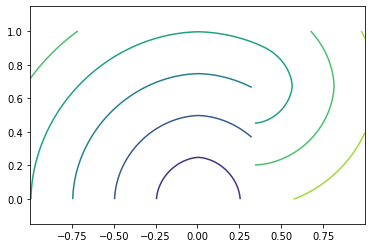

In [119]:
plt.axis('equal')
plt.contour(*X,hfmOut['values'])

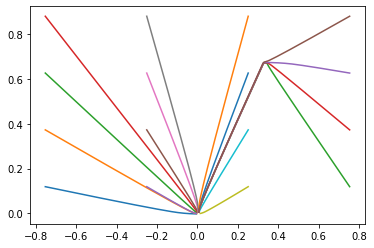

In [120]:
for geo in hfmOut['geodesics']: plt.plot(*geo)

## 2. Curvature penalized metrics

In [130]:
n = 300 if large_instances else 100 
nTheta = 96 if large_instances else 64
hfmIn = HFMUtils.dictIn({
    'model':'Elastica2',
    'seeds':cp.array([[0.,0.,np.pi]]),
    'exportValues':1,
    'cost':1,
    'xi':0.4,
    'count_updates':True,
#    'bound_active_blocks':True,
})
hfmIn.SetRect([[-1,1],[0,1]],dimx=n+1,sampleBoundary=True)
hfmIn['dims'] = np.append(hfmIn['dims'],nTheta)

tips = hfmIn.Grid(dims=(4,4,4))
tips = np.moveaxis(tips.reshape(3,-1),0,-1)
hfmIn['tips'] = tips

Casting output of function array from float64 to float32


In [131]:
X = hfmIn.Grid()
walls = np.logical_and(X[0]==X[0,int(2*n/3)],X[1]<=2./3.)
hfmIn['walls']=walls

In [132]:
hfmOut = hfmIn.RunGPU()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
odict_keys(['values', 'geom', 'seedTags', 'rhs', 'wallDist'])
Running the eikonal GPU kernel
GPU kernel eikonal ran for 1.3195013999938965 seconds, and 228 iterations.
Post-Processing


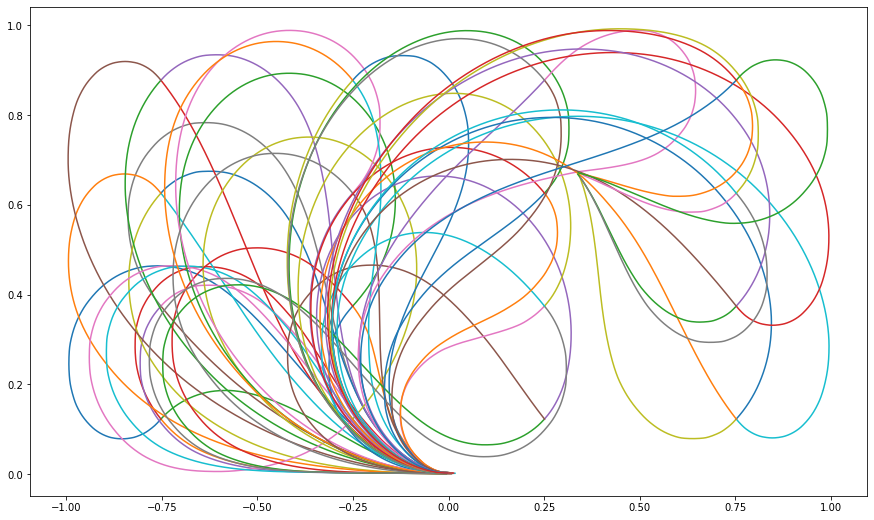

In [135]:
plt.figure(figsize=(15,9))
for geo in hfmOut['geodesics']: plt.plot(geo[0],geo[1])

TODO: Distance computation seems ok, but geodesics reaching the wall tip believe they are at seed...

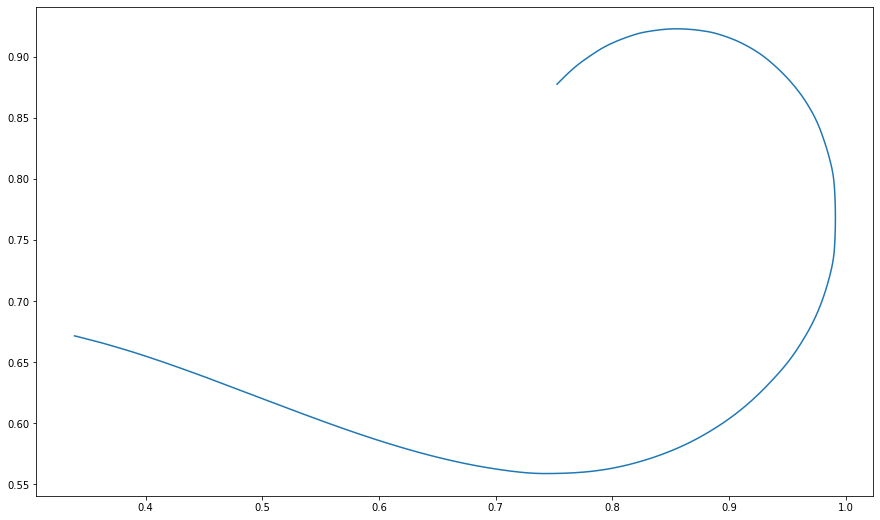

In [144]:
plt.figure(figsize=(15,9))
for geo in hfmOut['geodesics'][62:63]: plt.plot(geo[0],geo[1])

In [136]:
hfmOut['geodesic_stopping_criteria']

['PastSeed',
 'AtSeed',
 'AtSeed',
 'AtSeed',
 'AtSeed',
 'AtSeed',
 'AtSeed',
 'AtSeed',
 'AtSeed',
 'AtSeed',
 'AtSeed',
 'PastSeed',
 'AtSeed',
 'AtSeed',
 'AtSeed',
 'PastSeed',
 'PastSeed',
 'AtSeed',
 'PastSeed',
 'PastSeed',
 'AtSeed',
 'AtSeed',
 'PastSeed',
 'PastSeed',
 'AtSeed',
 'AtSeed',
 'PastSeed',
 'PastSeed',
 'AtSeed',
 'AtSeed',
 'AtSeed',
 'PastSeed',
 'AtSeed',
 'InWall',
 'PastSeed',
 'PastSeed',
 'AtSeed',
 'AtSeed',
 'PastSeed',
 'PastSeed',
 'AtSeed',
 'AtSeed',
 'PastSeed',
 'PastSeed',
 'AtSeed',
 'AtSeed',
 'AtSeed',
 'PastSeed',
 'AtSeed',
 'PastSeed',
 'PastSeed',
 'PastSeed',
 'AtSeed',
 'PastSeed',
 'PastSeed',
 'PastSeed',
 'AtSeed',
 'AtSeed',
 'PastSeed',
 'PastSeed',
 'AtSeed',
 'AtSeed',
 'AtSeed',
 'PastSeed']